In [270]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
import warnings

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import itertools

In [29]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

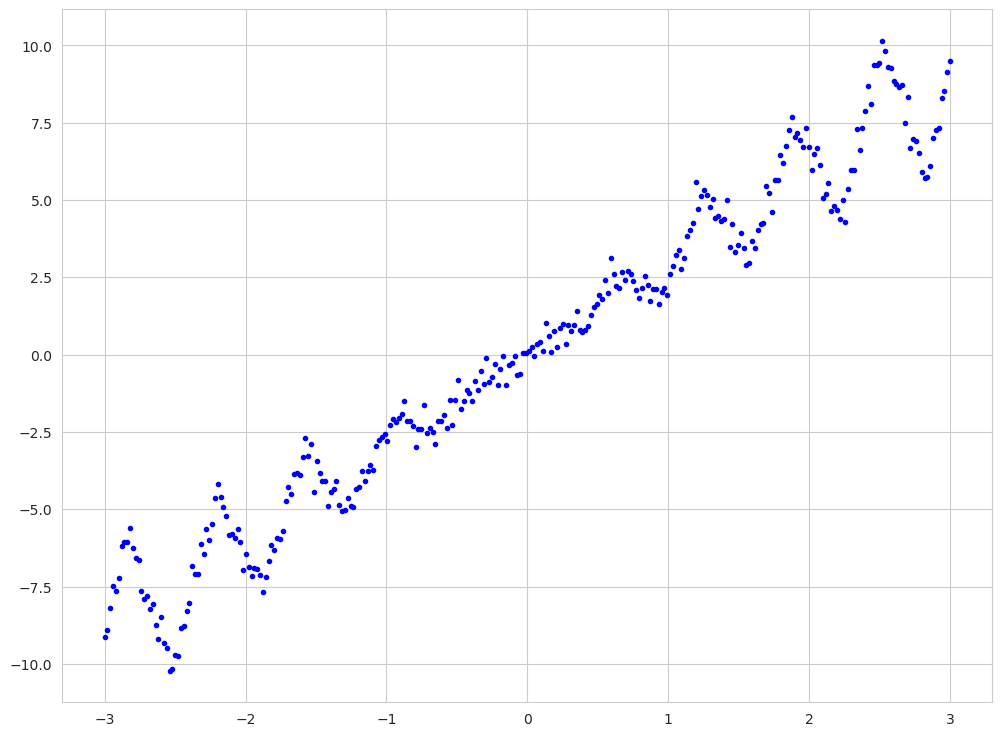

In [30]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [31]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", xlabel = "$x_1$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    if xlabel: # add xlabel param not to plot it on every subplot later
        plt.xlabel(xlabel, fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", alpha=0.8)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

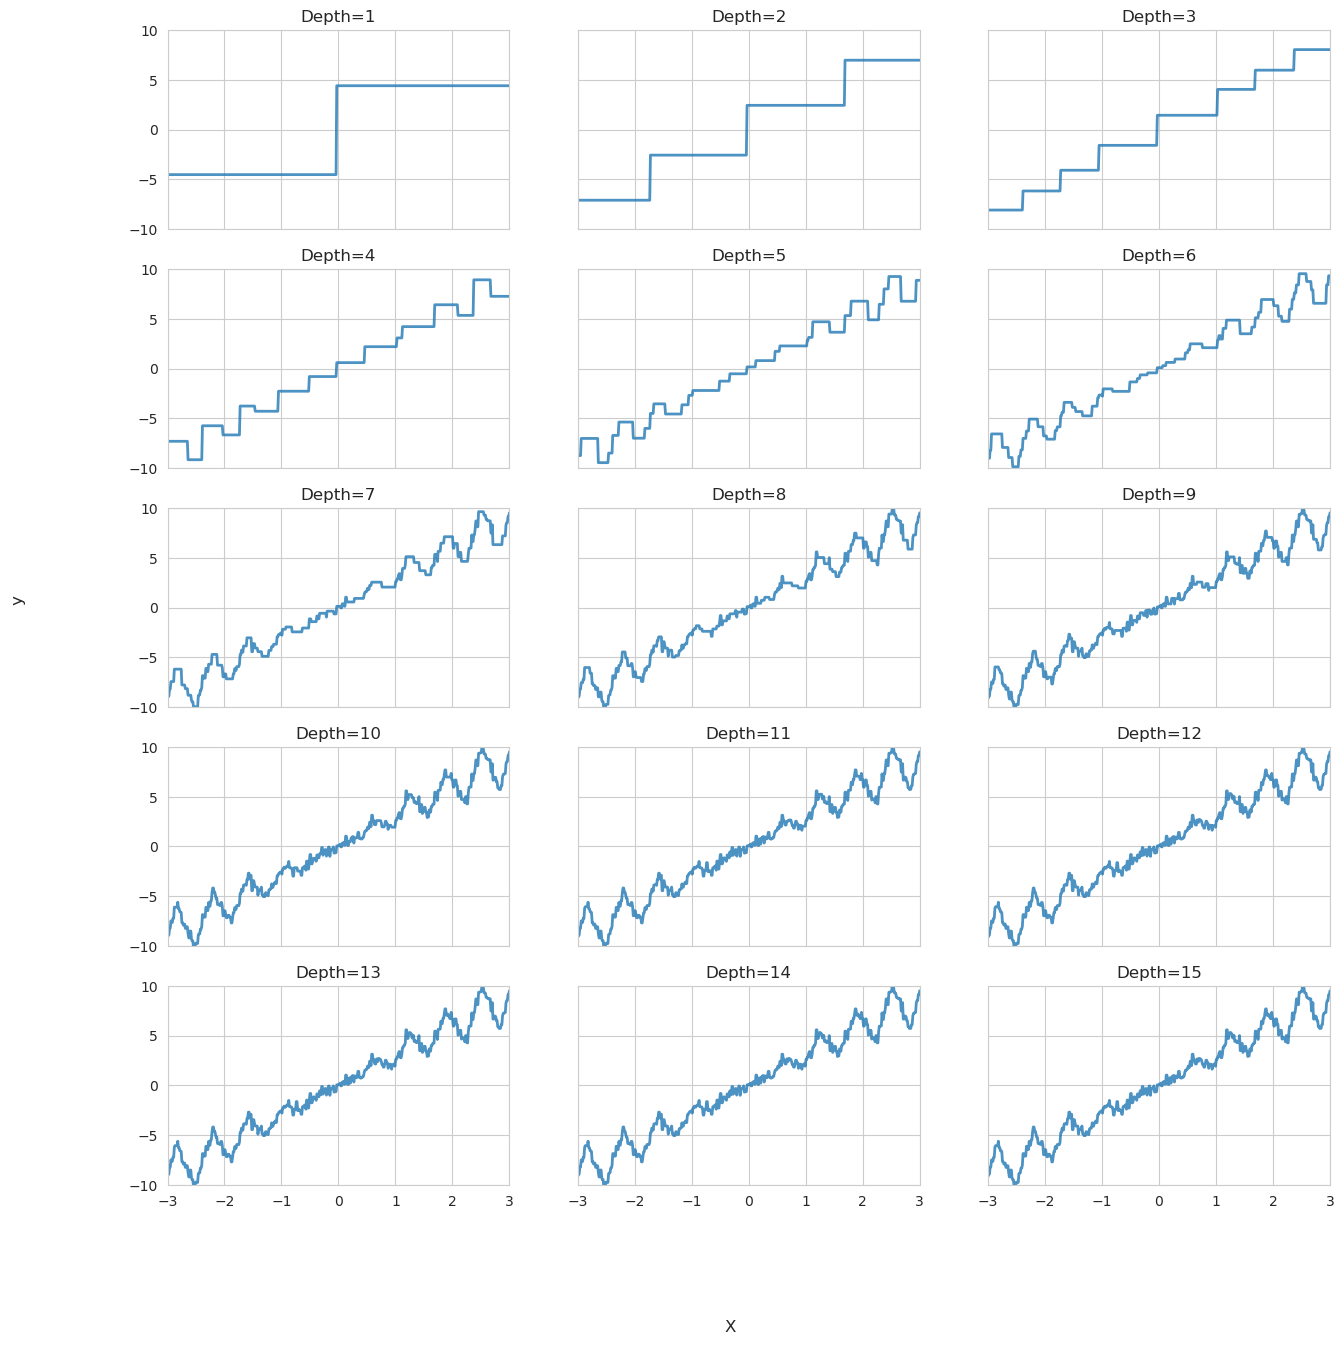

In [32]:
fig = plt.figure(figsize=(15, 15))
fig.supylabel("y")
fig.supxlabel("X")


init_subplot = 0
for depth in range(1, 16):
    ax = fig.add_subplot(5, 3, depth)
    ax.set_title(f"Depth={depth}")
    plot_regression_predictions(
        DecisionTreeRegressor(max_depth=depth, random_state=SEED).fit(X, y), X, y, ylabel=None, xlabel=None
    )

    if depth % 3 != 1:
        ax.set_yticklabels([])
    if depth not in range(13, 16):
        ax.set_xticklabels([])

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [33]:
p_values = np.arange(0, 1.01, step=0.001)
mus = []

imax = 100
imin = 51

for p in p_values:
    mus.append(
        sum(
            math.comb(imax, i) * p**i * (1 - p) ** (imax - i)
            for i in range(imin, imax + 1)
        )
    )

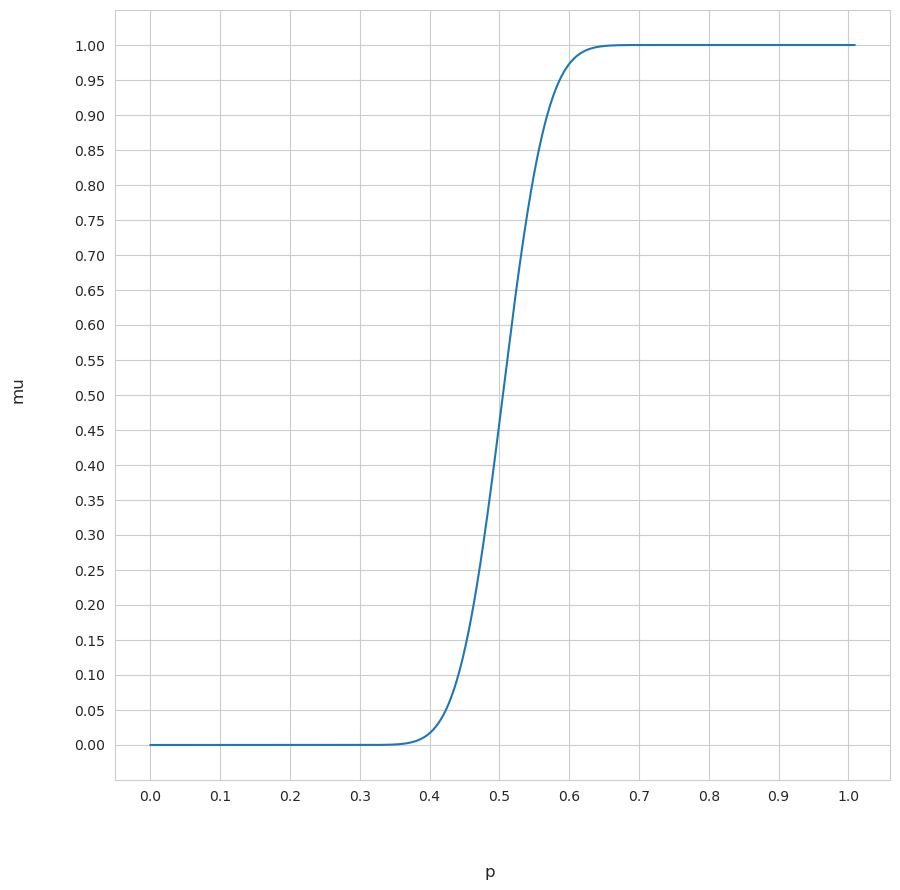

In [34]:
fig = plt.figure(figsize=(10, 10))
fig.supylabel("mu")
fig.supxlabel("p")

plt.plot(p_values, mus)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.xticks(np.arange(0, 1.1, step=0.1));

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [35]:
p = 0.65
mus = []

for n in range(1, 101, 2):
    mus.append(
        sum(
            math.comb(n, i) * p**i * (1 - p) ** (n - i)
            for i in range(n // 2 + n % 2, n + 1)
        )
    )

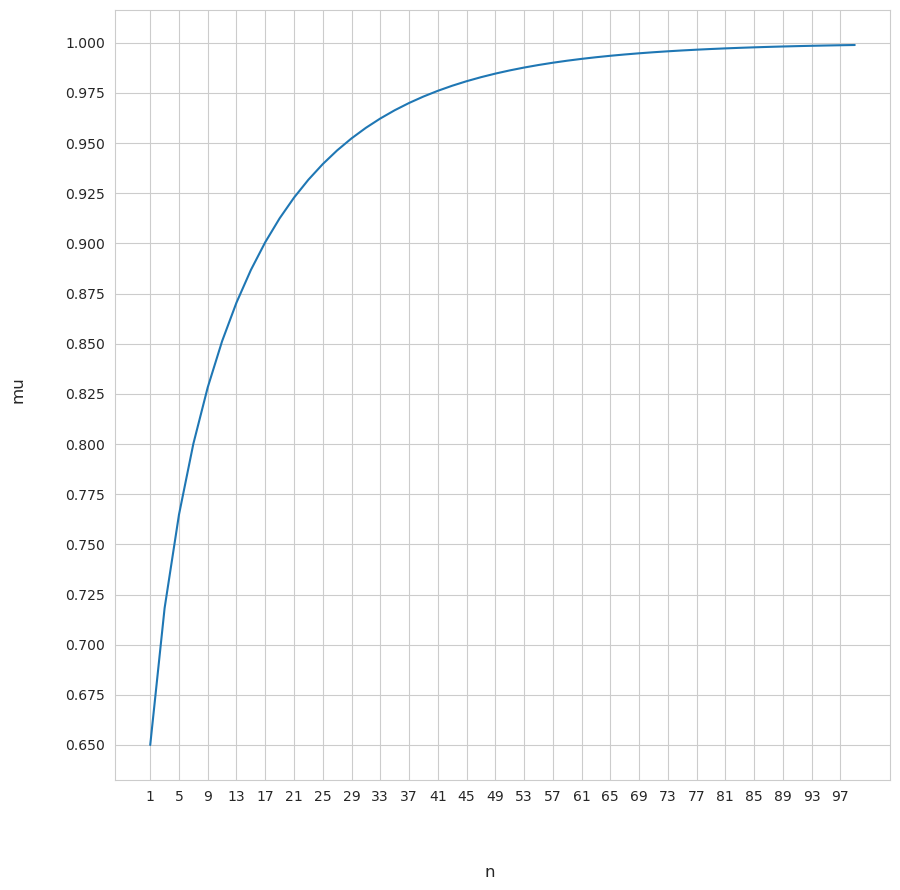

In [36]:
fig = plt.figure(figsize=(10, 10))
fig.supylabel("mu")
fig.supxlabel("n")

plt.plot(range(1, 101, 2), mus)
plt.yticks(np.arange(0.65, 1.025, step=0.025))
plt.xticks(np.arange(1, 101, 4));

Опишите ваши наблюдения:

* we can see, that 29 classifiers is enough to create model with correct prediction probability > 0.95 if each classifier has probability of correct prediction at 0.65
* at 101 classifiers p of correct majority voting is greater than 0.95 already at 0.6 probability
* so, we can assume that we need more classifiers for worse classifiers, and less for better classifiers

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [37]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        for indx in range(0, self.n_estimators):
            np.random.seed(self.random_state + indx)

            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], size=self.max_features, replace=False))

            indx_bootstrap = np.random.choice(
                X.shape[0], size=X.shape[0], replace=False
            ).reshape(X.shape[0], 1)
            X_bootstrap = X[indx_bootstrap, self.feat_ids_by_tree[indx]]
            y_bootstrap = y[indx_bootstrap]

            dt_model = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            self.trees.append(dt_model.fit(X_bootstrap, y_bootstrap))

        return self

    def predict_proba(self, X):

        probas = []
        for tree_features, tree in zip(self.feat_ids_by_tree, self.trees):
            probas.append(tree.predict_proba(X[:, tree_features]))

        return np.mean(probas, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [38]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

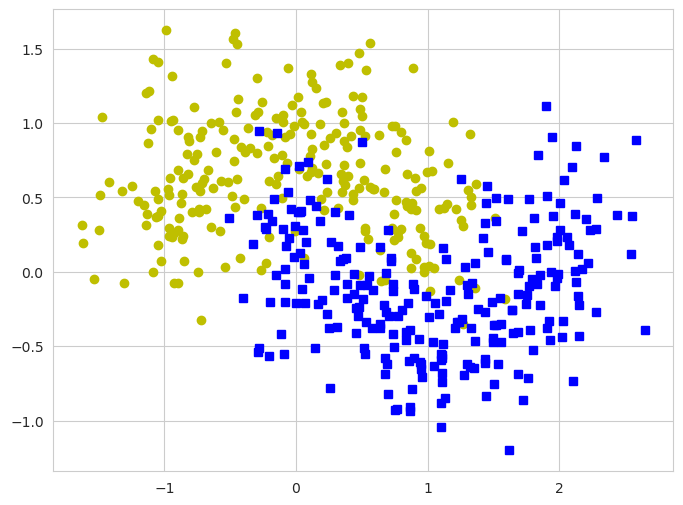

In [39]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [40]:
rf_model = RandomForestClassifierCustom(max_depth=5, max_features=2, random_state=SEED)
rf_model.fit(X, y)

RandomForestClassifierCustom(max_depth=5, max_features=2)

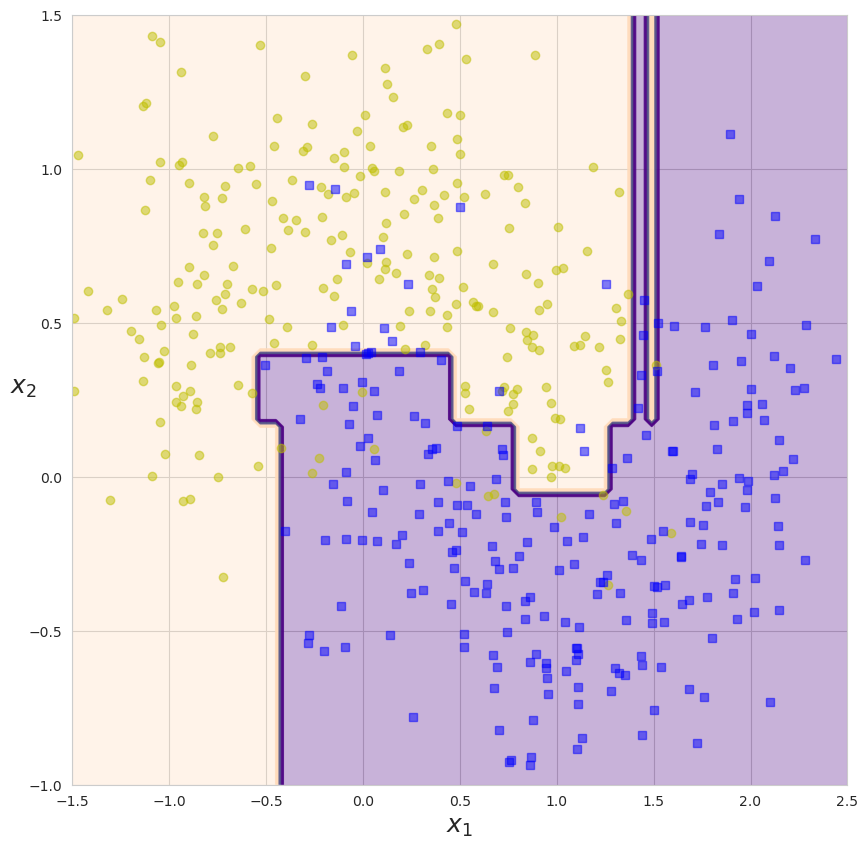

In [41]:
fig = plt.figure(figsize=(10, 10))
plot_decision_boundary(rf_model, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Let's use gridsearch

In [42]:
param_grid = {
    "max_depth": np.arange(3, 15),
    "max_features": [1, 2],
    "n_estimators": range(1, 101, 2),
    "random_state": [SEED],
}

In [43]:
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="f1",
    n_jobs=-1,
)

In [44]:
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestClassifierCustom(max_depth=5,
                                                    max_features=2),
             n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': [1, 2],
                         'n_estimators': range(1, 101, 2),
                         'random_state': [111]},
             scoring='f1')

In [45]:
best_params = grid_search.best_params_
best_params

{'max_depth': 5, 'max_features': 2, 'n_estimators': 1, 'random_state': 111}

In [46]:
rf_model = RandomForestClassifierCustom(**best_params)
rf_model.fit(X, y)

RandomForestClassifierCustom(max_depth=5, max_features=2, n_estimators=1)

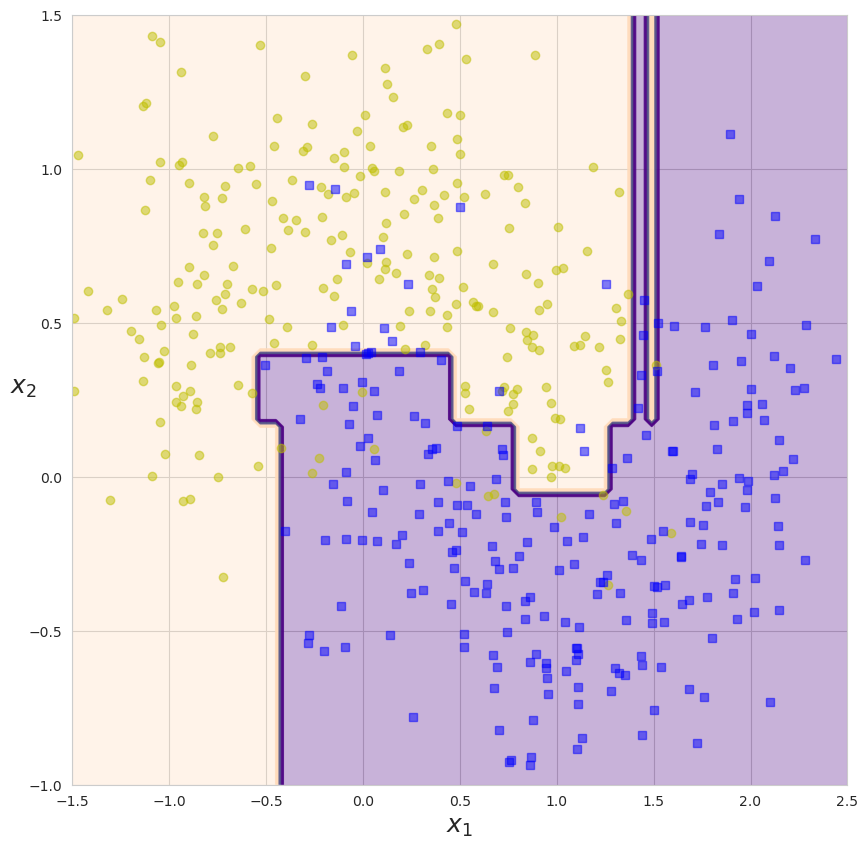

In [47]:
fig = plt.figure(figsize=(10, 10))
plot_decision_boundary(rf_model, X, y)

I don't really like n_estimators here and overall look

In [48]:
param_grid = {
    "max_depth": np.arange(3, 5),
    "max_features": [1, 2],
    "n_estimators": range(1, 100, 2),
    "random_state": [SEED],
}

In [49]:
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="f1",
    n_jobs=-1,
)

In [50]:
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestClassifierCustom(max_depth=5, max_features=2,
                                                    n_estimators=1),
             n_jobs=-1,
             param_grid={'max_depth': array([3, 4]), 'max_features': [1, 2],
                         'n_estimators': range(1, 100, 2),
                         'random_state': [111]},
             scoring='f1')

In [51]:
grid_search.best_params_

{'max_depth': 4, 'max_features': 2, 'n_estimators': 1, 'random_state': 111}

In [52]:
best_params = grid_search.best_params_
#best_params['n_estimators'] = 2

In [53]:
rf_model = RandomForestClassifierCustom(**best_params)
rf_model.fit(X, y)

RandomForestClassifierCustom(max_depth=4, max_features=2, n_estimators=1)

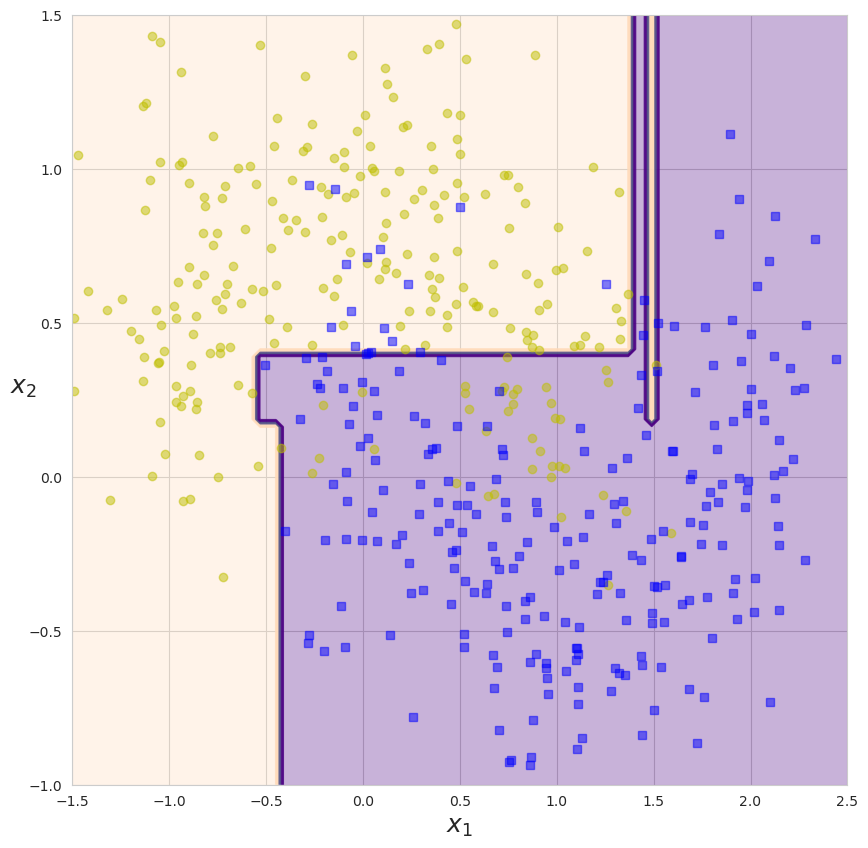

In [54]:
fig = plt.figure(figsize=(10, 10))
plot_decision_boundary(rf_model, X, y)

Bigger n_estimators doesn't help as output estimators are probably highly correlated

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [55]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [58]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
X_train.shape

(426, 30)

In [70]:
corr_dct = {
    n: base_model_pair_correlation(
        RandomForestClassifier(max_features=n, max_depth=15).fit(X_train, y_train), X_train
    )
    for n in range(1, X_train.shape[1] + 1)
}

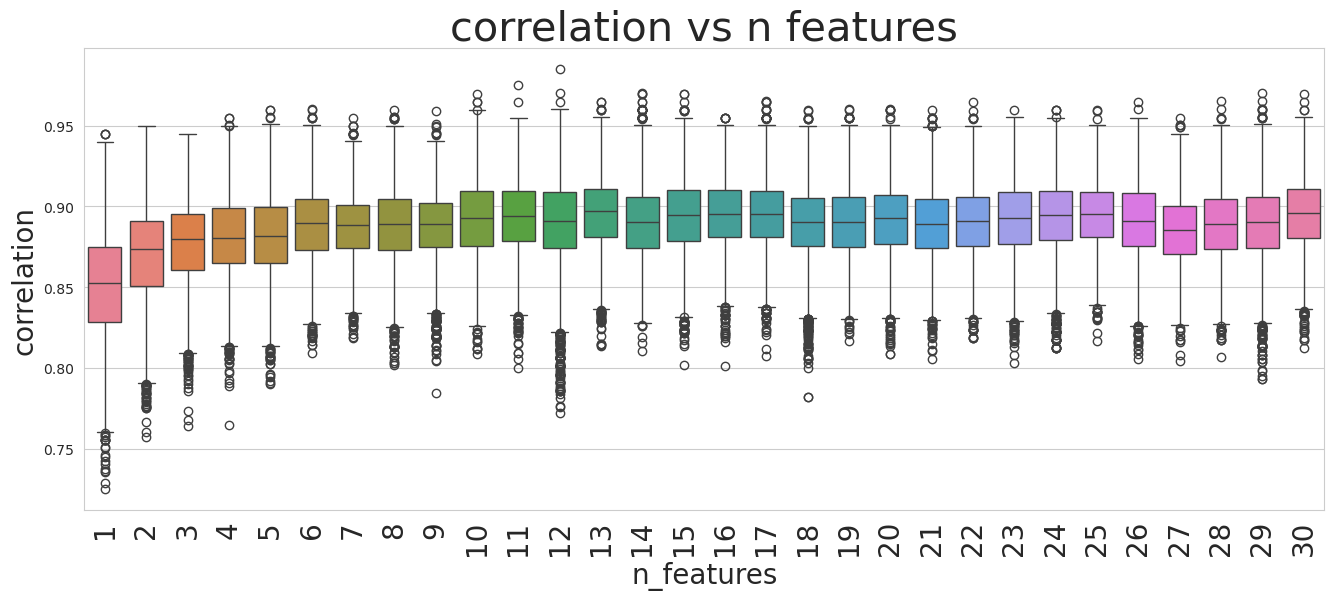

In [71]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=corr_dct)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("n_features", size=20)
plt.ylabel("correlation", size=20)
plt.title("correlation vs n features", size=30)
plt.xticks(size=20)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [72]:
corr_dct = {
    n: base_model_pair_correlation(
        RandomForestClassifier(max_depth=n).fit(X_train, y_train), X_train
    )
    for n in range(1, 20 + 1)
}

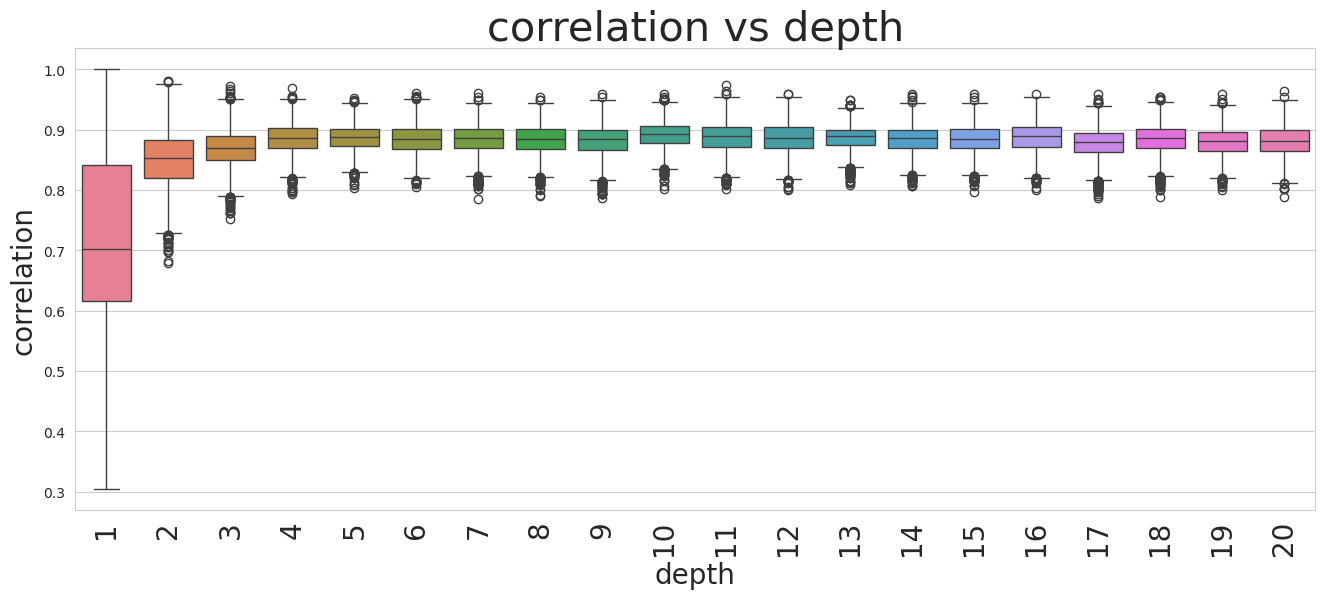

In [75]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=corr_dct)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("depth", size=20)
plt.ylabel("correlation", size=20)
plt.title("correlation vs depth", size=30)
plt.xticks(size=20)
plt.show()

Опишите ваши наблюдения:

* for n features: higher max_features yeild higher correlation up until n_features=6, then it just wobbles around ~0.88
* for depth parameter we see very sismilar behaviour, correlation rises till depth=6, then it fluctuates with no significant change

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [97]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [98]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]

<Axes: xlabel='target', ylabel='Count'>

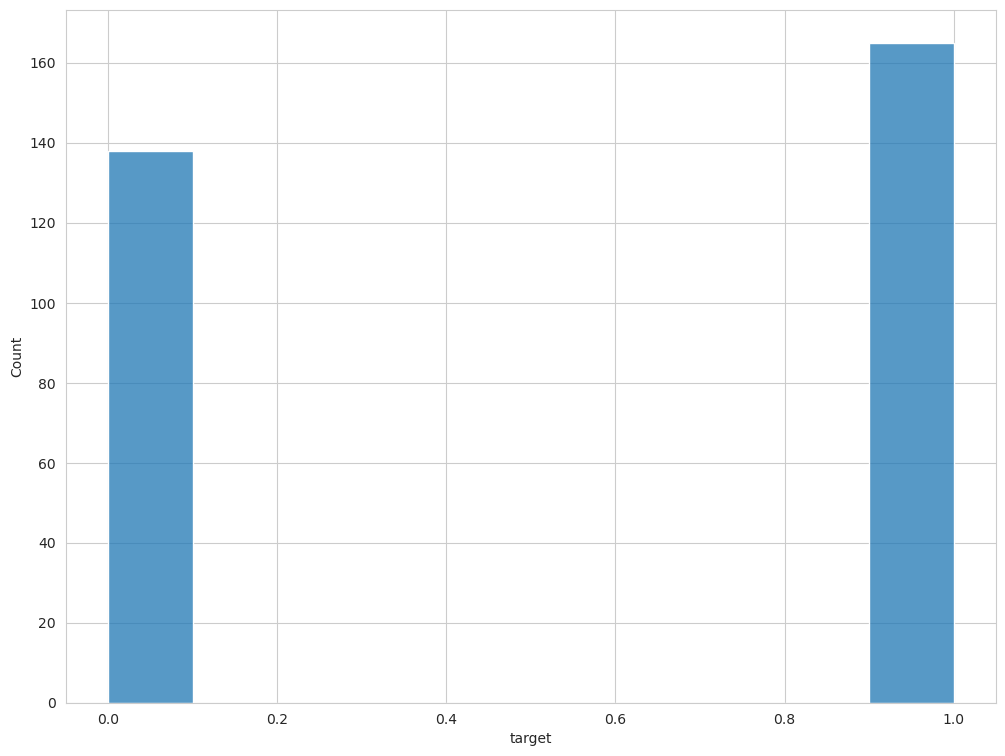

In [113]:
sns.histplot(y)

Class balance - OK

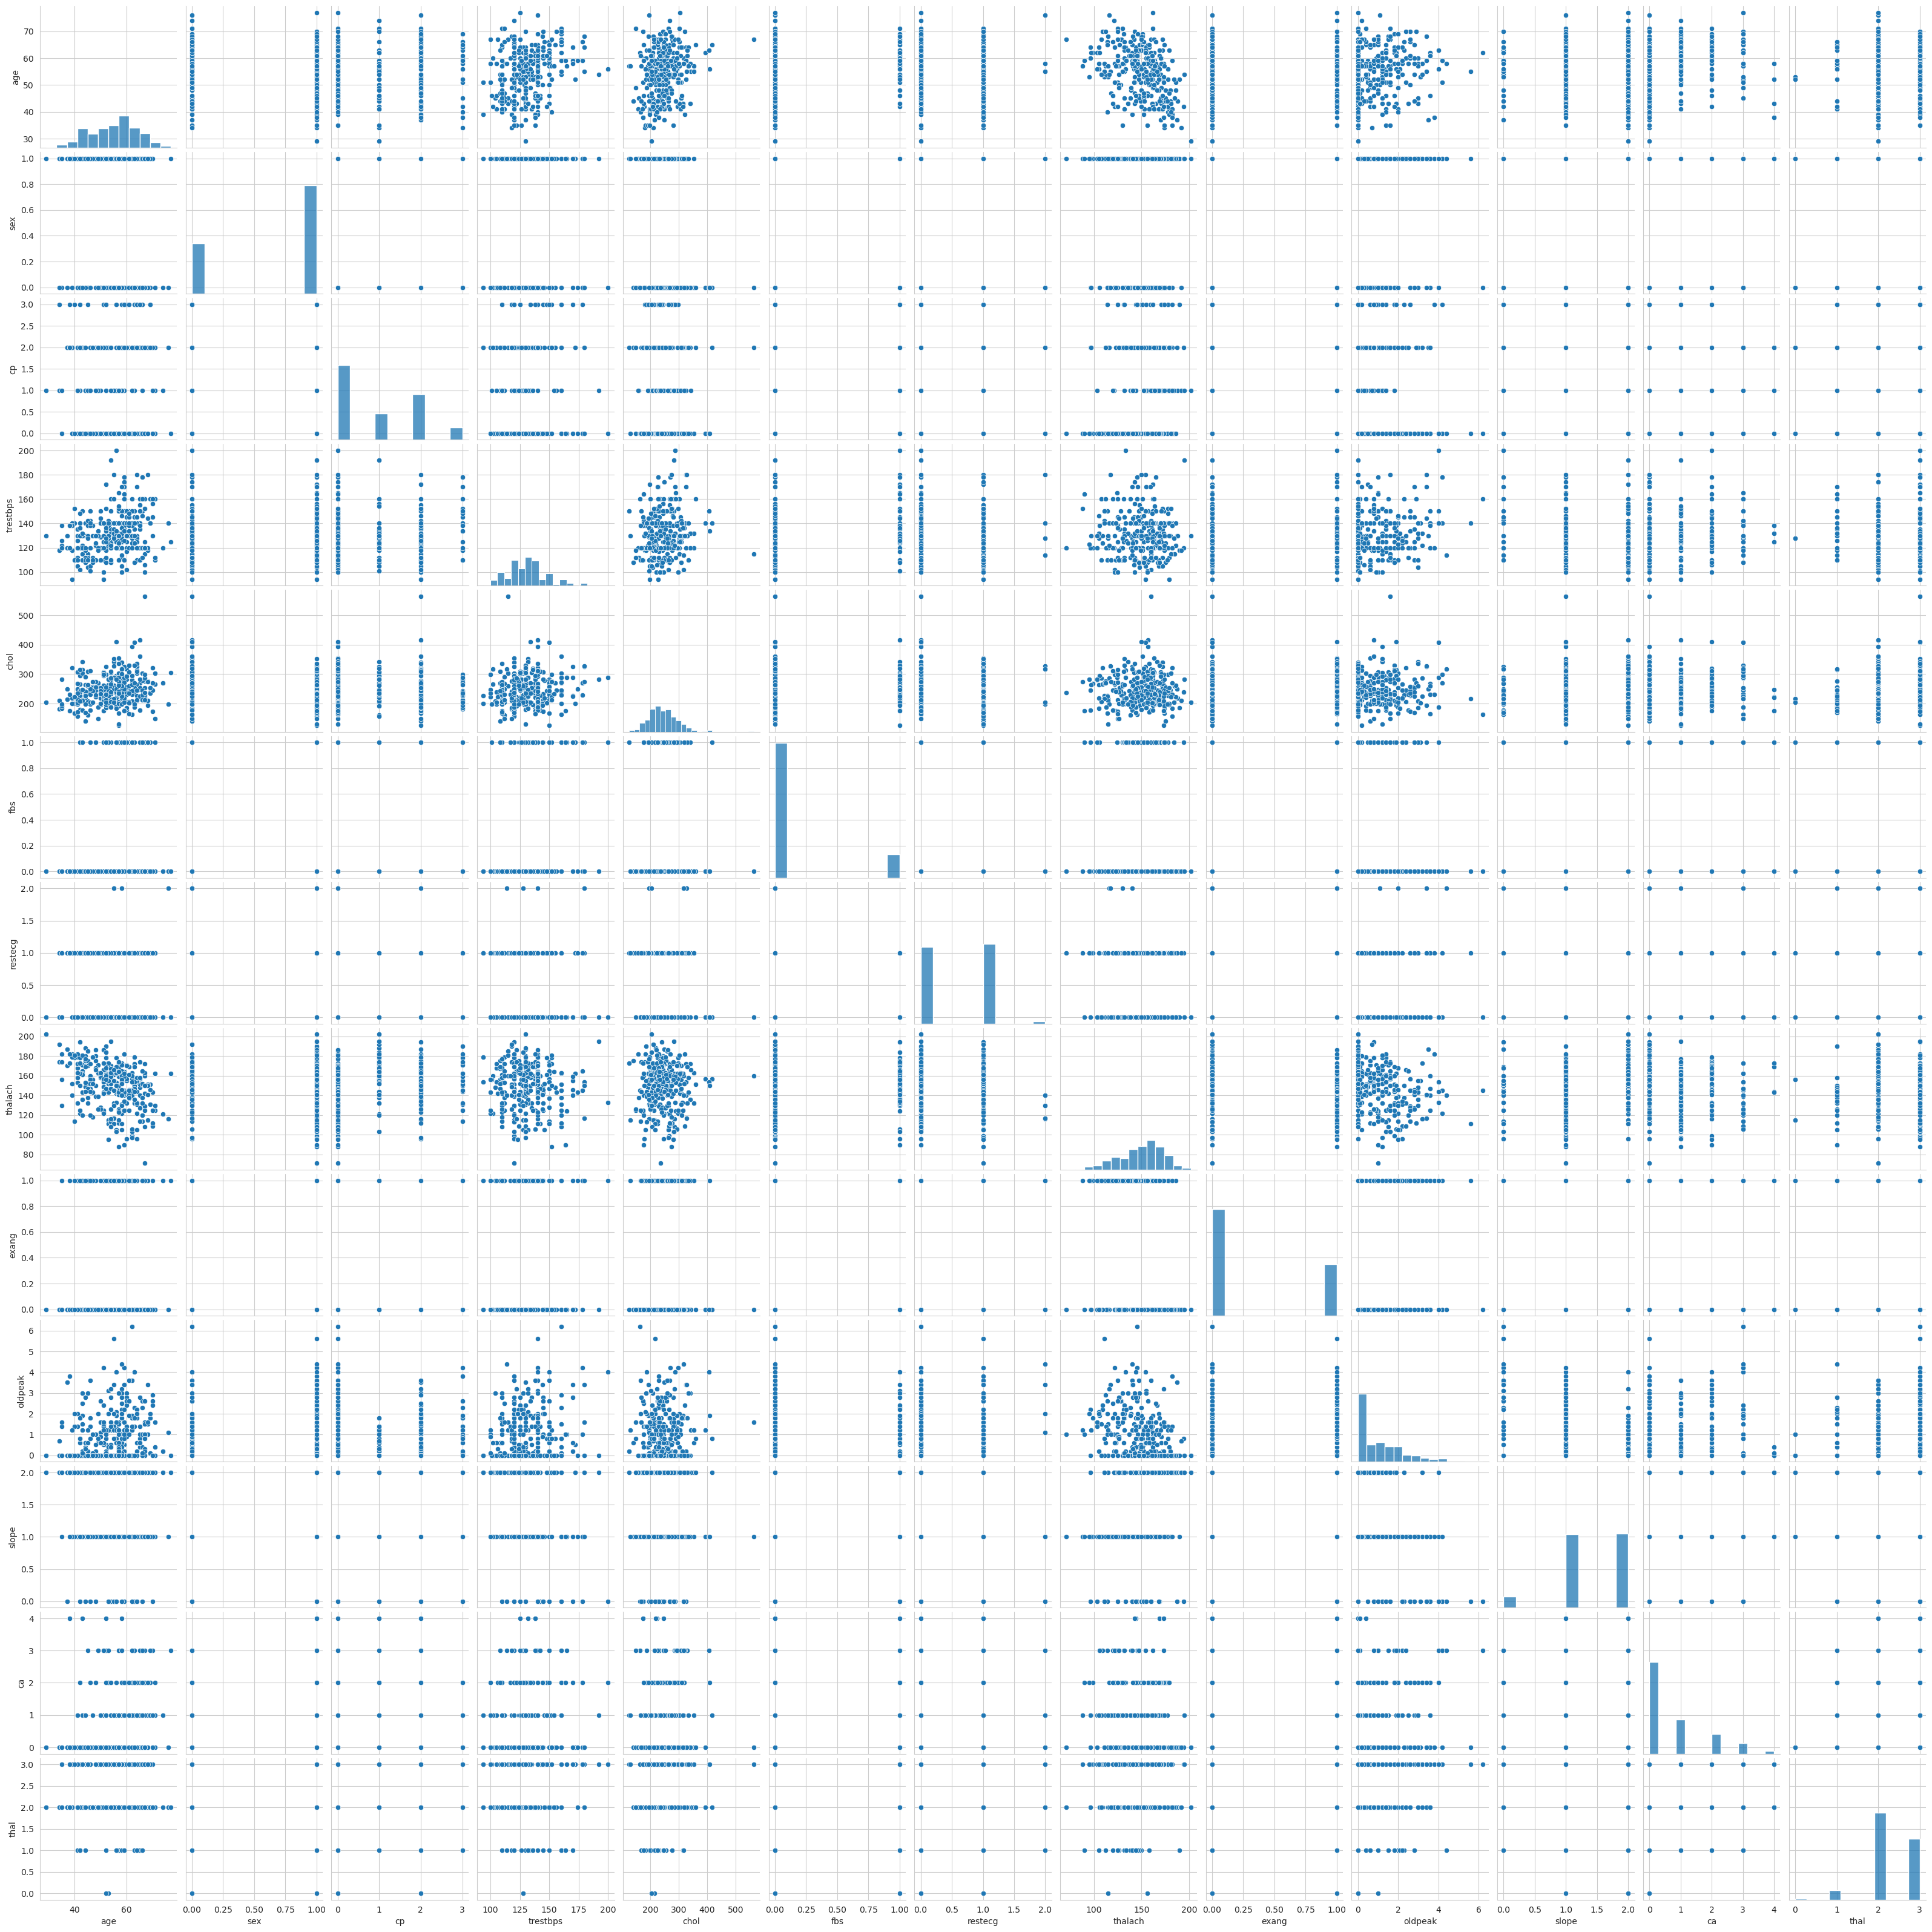

In [86]:
sns.pairplot(X);

Let's encode cat values

In [104]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

In [107]:
X = pd.get_dummies(X, columns=categorical_features)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [271]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [272]:
dt = DecisionTreeClassifier(
    random_state=SEED, max_depth=10, min_samples_leaf=10, 
)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED, n_jobs=-1)
etc = ExtraTreesClassifier(random_state=SEED, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
svc_lin = SVC(kernel="linear", probability=True, random_state=SEED)
svc_rbf = SVC(kernel="rbf", probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, n_jobs=-1)
lgbm_rf = lightgbm.LGBMClassifier(
    boosting_type="rf",
    bagging_freq=1,
    bagging_fraction=0.7,
    random_state=SEED,
    n_jobs=-1,
)
xgb = xgboost.XGBClassifier(random_state=SEED, n_jobs=-1)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED, n_jobs=-1)
lr = LogisticRegression(solver="liblinear", max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_hard = VotingClassifier(estimators=base_models, voting="hard", n_jobs=-1)
voting_soft = VotingClassifier(estimators=base_models, voting="soft", n_jobs=-1)

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [273]:
scores_dct = {}
base_models_names = [x[0] for x in base_models]
base_models_names = base_models_names + ["voting_hard", "voting_soft"]

for model_name, model in zip(base_models_names, [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]): 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    scores_dct[model_name] = scores.mean()
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.7668174962292609
RandomForestClassifier: 0.8371297441917029
CatBoostClassifier: 0.8339848034412664
ExtraTreesClassifier: 0.8317782067782068
KNeighborsClassifier: 0.8333023355245577
SVC: 0.832843137254902
SVC: 0.8297197376267144
XGBClassifier: 0.7980756072528224
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [274]:
scores_dct

{'DT': 0.7668174962292609,
 'RF': 0.8371297441917029,
 'ETC': 0.8339848034412664,
 'KNN': 0.8317782067782068,
 'SVC_LIN': 0.8333023355245577,
 'SVC_RBF': 0.832843137254902,
 'CAT': 0.8297197376267144,
 'LGBM': 0.7980756072528224,
 'LGBM_RF': 0.8231255645889792,
 'XGB': 0.8445754787218203,
 'XGB_RF': 0.826898326898327,
 'LR': 0.8239538239538241,
 'NB': 0.6922033008821075,
 'voting_hard': 0.8493656184301445,
 'voting_soft': 0.8563976108279906}

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [275]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [276]:
hard = base_model_pair_correlation_for_voting_clf(voting_hard.fit(X_train, y_train), X_train)
soft = base_model_pair_correlation_for_voting_clf(voting_soft.fit(X_train, y_train), X_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.377258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initsc

In [277]:
hard_df = pd.DataFrame(hard, columns=["model_1", "model_2", "corr"])
hard_df.sort_values("corr", ascending=True).head(20)

model_1  \
41  KNeighborsClassifier(n_jobs=-1, weights='dista...   
32  (ExtraTreeClassifier(random_state=481767252), ...   
74  XGBClassifier(base_score=None, booster=None, c...   
11  DecisionTreeClassifier(max_depth=10, min_sampl...   
67        LGBMClassifier(n_jobs=-1, random_state=111)   
62  <catboost.core.CatBoostClassifier object at 0x...   
22  (DecisionTreeClassifier(max_features='sqrt', r...   
76  XGBRFClassifier(base_score=None, booster=None,...   
56            SVC(probability=True, random_state=111)   
71  LGBMClassifier(bagging_fraction=0.7, bagging_f...   
77  LogisticRegression(max_iter=10000, solver='lib...   
49  SVC(kernel='linear', probability=True, random_...   
24  (ExtraTreeClassifier(random_state=481767252), ...   
33  KNeighborsClassifier(n_jobs=-1, weights='dista...   
37  KNeighborsClassifier(n_jobs=-1, weights='dista...   
28  (ExtraTreeClassifier(random_state=481767252), ...   
31  (ExtraTreeClassifier(random_state=481767252), ...   
40  KNeighborsClassifier(n_jobs=-1, weights='dista...   
46  SVC(kernel='linear', probability=True, random_...   
68  LGBMClassifier(bagging_fraction=0.7, bagging_f...   

                                              model_2      corr  
41                                       GaussianNB()  0.524463  
32                                       GaussianNB()  0.524463  
74                                       GaussianNB()  0.550809  
11                                       GaussianNB()  0.579535  
67                                       GaussianNB()  0.580494  
62                                       GaussianNB()  0.600873  
22                                       GaussianNB()  0.611934  
76                                       GaussianNB()  0.653375  
56                                       GaussianNB()  0.685266  
71                                       GaussianNB()  0.686847  
77                                       GaussianNB()  0.705166  
49                                       GaussianNB()  0.714254  
24  SVC(kernel='linear', probability=True, random_...  0.742208  
33  SVC(kernel='linear', probability=True, random_...  0.742208  
37  LGBMClassifier(bagging_fraction=0.7, bagging_f...  0.752213  
28  LGBMClassifier(bagging_fraction=0.7, bagging_f...  0.752213  
31  LogisticRegression(max_iter=10000, solver='lib...  0.775566  
40  LogisticRegression(max_iter=10000, solver='lib...  0.775566  
46  XGBClassifier(base_score=None, booster=None, c...  0.775626  
68  XGBClassifier(base_score=None, booster=None, c...  0.784438

In [278]:
soft_df = pd.DataFrame(soft, columns=["model_1", "model_2", "corr"])
soft_df.sort_values("corr", ascending=False).head(20)

model_1  \
23  (ExtraTreeClassifier(random_state=481767252), ...   
38  KNeighborsClassifier(n_jobs=-1, weights='dista...   
29  (ExtraTreeClassifier(random_state=481767252), ...   
57  <catboost.core.CatBoostClassifier object at 0x...   
64        LGBMClassifier(n_jobs=-1, random_state=111)   
16  (DecisionTreeClassifier(max_features='sqrt', r...   
59  <catboost.core.CatBoostClassifier object at 0x...   
17  (DecisionTreeClassifier(max_features='sqrt', r...   
36  KNeighborsClassifier(n_jobs=-1, weights='dista...   
27  (ExtraTreeClassifier(random_state=481767252), ...   
19  (DecisionTreeClassifier(max_features='sqrt', r...   
26  (ExtraTreeClassifier(random_state=481767252), ...   
35  KNeighborsClassifier(n_jobs=-1, weights='dista...   
12  (DecisionTreeClassifier(max_features='sqrt', r...   
13  (DecisionTreeClassifier(max_features='sqrt', r...   
60  <catboost.core.CatBoostClassifier object at 0x...   
48  SVC(kernel='linear', probability=True, random_...   
20  (DecisionTreeClassifier(max_features='sqrt', r...   
55            SVC(probability=True, random_state=111)   
65        LGBMClassifier(n_jobs=-1, random_state=111)   

                                              model_2      corr  
23  KNeighborsClassifier(n_jobs=-1, weights='dista...  1.000000  
38  XGBClassifier(base_score=None, booster=None, c...  0.997192  
29  XGBClassifier(base_score=None, booster=None, c...  0.997192  
57        LGBMClassifier(n_jobs=-1, random_state=111)  0.995867  
64  XGBClassifier(base_score=None, booster=None, c...  0.995140  
16  <catboost.core.CatBoostClassifier object at 0x...  0.991537  
59  XGBClassifier(base_score=None, booster=None, c...  0.990491  
17        LGBMClassifier(n_jobs=-1, random_state=111)  0.988406  
36        LGBMClassifier(n_jobs=-1, random_state=111)  0.986484  
27        LGBMClassifier(n_jobs=-1, random_state=111)  0.986484  
19  XGBClassifier(base_score=None, booster=None, c...  0.982179  
26  <catboost.core.CatBoostClassifier object at 0x...  0.979832  
35  <catboost.core.CatBoostClassifier object at 0x...  0.979832  
12  (ExtraTreeClassifier(random_state=481767252), ...  0.971962  
13  KNeighborsClassifier(n_jobs=-1, weights='dista...  0.971962  
60  XGBRFClassifier(base_score=None, booster=None,...  0.962355  
48  LogisticRegression(max_iter=10000, solver='lib...  0.962056  
20  XGBRFClassifier(base_score=None, booster=None,...  0.959078  
55  LogisticRegression(max_iter=10000, solver='lib...  0.954665  
65  XGBRFClassifier(base_score=None, booster=None,...  0.949389

In [279]:
base_models = [
    ("DT", dt),
    ("RF", rf),
    #("ETC", etc),
    ("KNN", knn),
    ("SVC_LIN", svc_lin),
    ("SVC_RBF", svc_rbf),
    #("CAT", cat),
    ("LGBM", lgbm),
    #("LGBM_RF", lgbm_rf),
    ("XGB", xgb),
    ("XGB_RF", xgb_rf),
    ("LR", lr),
    ("NB", nb),
]

combs=[]

for i in range(5, 6):
    els = [list(x) for x in itertools.combinations(base_models, i)]
    combs.extend(els)

In [280]:
len(combs)

252

let's try bruteforce

In [238]:
warnings.filterwarnings("ignore")

scores_dct = {'score': [], 'models': []}
for indx, comb in enumerate(combs):
    voting_hard = VotingClassifier(estimators=comb, voting="hard", n_jobs=-1)
    scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1").mean()
    scores_dct['score'].append(scores)
    scores_dct['models'].append(comb)
    print(indx)

0
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [258]:
df = pd.DataFrame(scores_dct).sort_values("score", ascending=False).reset_index(drop=True)

In [263]:
df.iloc[0,:]["models"]

[('DT',
  DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)),
 ('RF', RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=111)),
 ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)),
 ('SVC_RBF', SVC(probability=True, random_state=111)),
 ('NB', GaussianNB())]

let's try voting tuning...

In [264]:
base_models = [
    ("DT", dt),
    ("RF", rf),
    # ("ETC", etc),
    # ("KNN", knn),
    ("SVC_LIN", svc_lin),
    ("SVC_RBF", svc_rbf),
    # ("CAT", cat),
    #("LGBM", lgbm),
    # ("LGBM_RF", lgbm_rf),
    # ("XGB", xgb),
    #("XGB_RF", xgb_rf),
    #("LR", lr),
    ("NB", nb),
]


voting_hard = VotingClassifier(estimators=base_models, n_jobs=-1)

In [265]:
params = {
    "voting": ["hard", "soft"],
    "weights": [
        (1, 1, 1, 1, 1),
        (2, 1, 1, 1, 1),
        (1, 2, 1, 1, 1),
        (1, 1, 2, 1, 1),
        (1, 1, 1, 2, 1),
        (1, 1, 1, 1, 2),
        (1, 1, 1, 2, 2),
        (2, 1, 1, 1, 2),
    ],
}

In [266]:
grid = GridSearchCV(voting_hard, params)
grid.fit(X, y)

GridSearchCV(estimator=VotingClassifier(estimators=[('DT',
                                                     DecisionTreeClassifier(max_depth=10,
                                                                            min_samples_leaf=10,
                                                                            random_state=111)),
                                                    ('RF',
                                                     RandomForestClassifier(n_estimators=50,
                                                                            n_jobs=-1,
                                                                            random_state=111)),
                                                    ('SVC_LIN',
                                                     SVC(kernel='linear',
                                                         probability=True,
                                                         random_state=111)),
                                                    ('SVC_RBF',
                                                     SVC(probability=True,
                                                         random_state=111)),
                                                    ('NB', GaussianNB())],
                                        n_jobs=-1),
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [(1, 1, 1, 1, 1), (2, 1, 1, 1, 1),
                                     (1, 2, 1, 1, 1), (1, 1, 2, 1, 1),
                                     (1, 1, 1, 2, 1), (1, 1, 1, 1, 2),
                                     (1, 1, 1, 2, 2), (2, 1, 1, 1, 2)]})

In [267]:
tuned_vc = VotingClassifier(base_models, **grid.best_params_, n_jobs=-1)

In [268]:
scores = cross_val_score(tuned_vc, X_train, y_train, cv=3, scoring="f1").mean()
scores

0.8279909120415448

HAHAHA
i don't really understand why result got even worse, maybe it's ловушка джокера

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

Это я после бесплодного тюнинга модели на несколько часов:
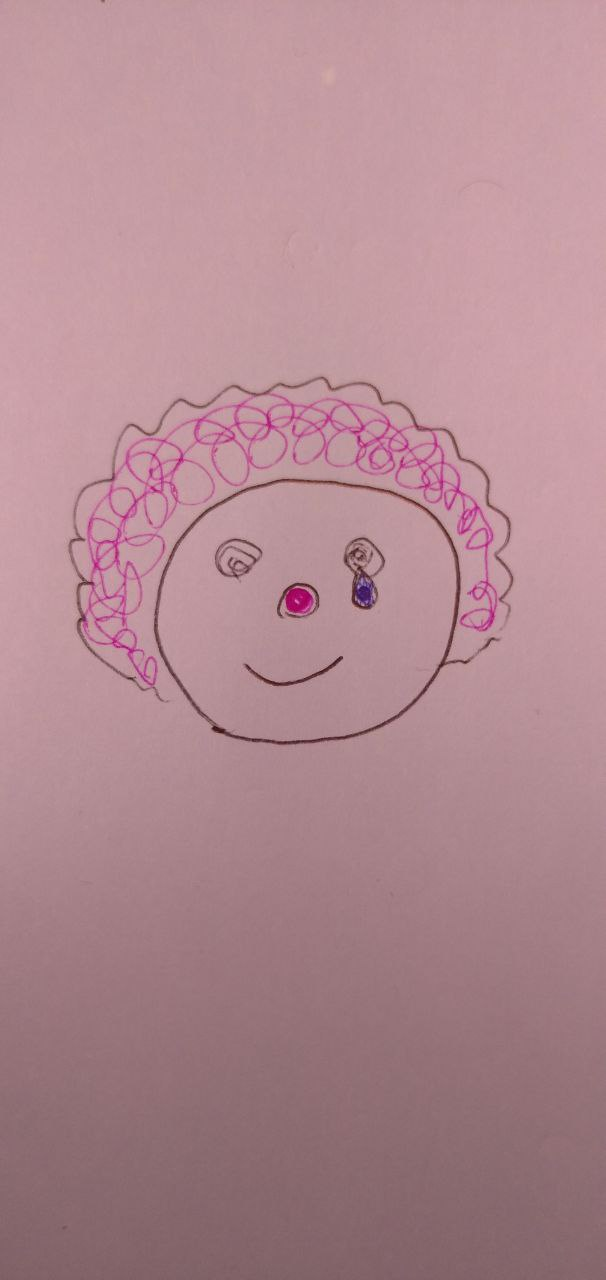

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Мне пока что очень интересно!